## import need lib

In [1]:
import mxnet as mx
from mxnet import gluon, image, autograd, nd
from mxnet.gluon import nn
from mxnet.contrib.ndarray import MultiBoxPrior, MultiBoxTarget, MultiBoxDetection
from mxnet import metric
from mxnet.gluon import model_zoo

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import time

import sys
sys.path.append("../")
from utils.utils import show_9_images, show_images, mkdir_if_not_exist

# dataset root dir
coins_root = "../dataset/"
sdl_root = coins_root + "sdl-coins/"
swiss_root = coins_root + "swiss-coins/"

data_shape = (3, 256, 256)
batch_size = 8
#mean = np.array([ 167.02477919,  157.20263027,  140.25492473])
#std = np.array([ 46.06696734,  47.12624331,  50.81295717])
rgb_mean = np.array([123, 117, 104])

ctx = mx.gpu(0)

## load evaluate data

In [2]:
def get_iterators(rec_prefix, data_shape, batch_size):
    class_names = ['1yuan', '0.5yuan']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size, 
        data_shape=data_shape,
        path_imgrec=rec_prefix + '_train.rec',
        path_imgidx=rec_prefix + '_train.idx',
        shuffle=True,
        mean=True,
        #std=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200,
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1,
        rand_mirror=True,
        aspect_ratio_range=(0.5, 2),
        pca_noise=0.01,
        #rand_gray=True
    )
    
    valid_iter = image.ImageDetIter(
        batch_size=batch_size, 
        data_shape=data_shape,
        path_imgrec=rec_prefix+'_val.rec',
        shuffle=False,
        mean=True,
        #std=True
    )
    
    return train_iter, valid_iter, class_names, num_class

train_data, valid_data, class_names, num_class = get_iterators(sdl_root+"rec/sdl", data_shape, batch_size)

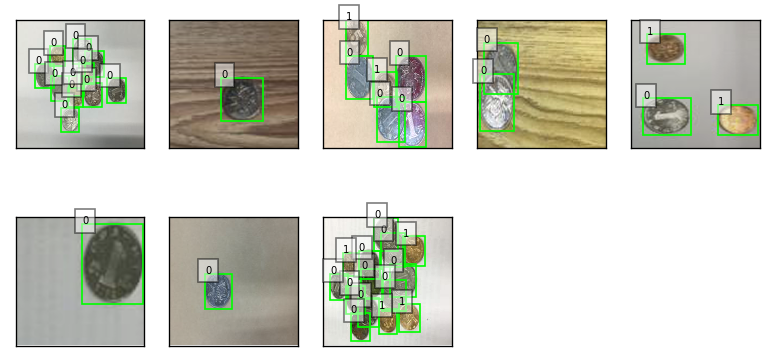

(8L, 14L, 5L)


In [3]:
"""
data plot
"""
mpl.rcParams['figure.dpi'] = 120

train_data.reset()
batch = train_data.next()
images = batch.data[0][:8]
labels = batch.label[0][:8]
show_images(images.asnumpy(), labels.asnumpy(), rgb_mean, show_text=True, fontsize=6)
#show_9_images(images.asnumpy(), labels, rgb_mean)
print labels.shape

## load net and evaluate

In [7]:
"""
model define
"""

def get_alexnet_conv(ctx):
    alexnet = model_zoo.vision.alexnet(pretrained=True, ctx=ctx)
    net = gluon.nn.HybridSequential()
    net.add(*(alexnet.features[:8]))
    return net

def get_vgg11bn_conv(ctx):
    vgg11bnnet = model_zoo.vision.vgg11_bn(pretrained=True, ctx=ctx)
    net = gluon.nn.HybridSequential()
    net.add(*(vgg11bnnet.features[:21]))
    return net

def get_mobilenet_1_conv(ctx):
    mobilenet = model_zoo.vision.mobilenet1_0()
    net = gluon.nn.HybridSequential()
    net.add(*mobilenet.features[:33])
    net.initialize(ctx=ctx)
    return net

def down_sample(num_filter):
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filter, kernel_size=3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filter))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

def class_predictor(num_class, num_anchors):
    return nn.Conv2D(num_anchors * (num_class + 1), kernel_size=3, strides=1, padding=1)

def box_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, strides=1, padding=1)

class SSD(nn.HybridBlock):
    def __init__(self, num_class, sizes_list, ratios_list, ctx, verbose=False, **kwargs):
        super(SSD, self).__init__(**kwargs)
        self.num_class = num_class
        self.sizes_list = sizes_list
        self.ratios_list = ratios_list
        self.num_anchors = num_anchors = (len(sizes_list[0]) + len(ratios_list[0]) - 1)
        self.verbose = verbose
        
        with self.name_scope():
            # part 1
#             self.body = nn.HybridSequential()
#             for filters in [16, 32, 64]:
#                 self.body.add(down_sample(filters))
            # self.body = get_vgg11bn_conv(ctx)
            self.body = get_vgg11bn_conv(ctx)

            # part 2
            self.downsamples = nn.HybridSequential()
            for _ in range(3):
                self.downsamples.add(down_sample(128))

            # part 3
            self.class_predictors = nn.HybridSequential()
            self.box_predictors = nn.HybridSequential()
            for _ in range(5):
                self.class_predictors.add(class_predictor(num_class, num_anchors))
                self.box_predictors.add(box_predictor(num_anchors))
                
            self.downsamples.initialize(ctx=ctx)
            self.class_predictors.initialize(ctx=ctx)
            self.box_predictors.initialize(ctx=ctx)
            
    def hybrid_forward(self, F, x):
        x = self.body(x)
        cls_preds = []
        box_preds = []
        anchors = []
        for i in range(5):
            cls_preds.append((self.class_predictors[i](x)).transpose((0, 2, 3, 1)).flatten())
            box_preds.append((self.box_predictors[i](x)).transpose((0, 2, 3, 1)).flatten())
            anchors.append(MultiBoxPrior(x, sizes=self.sizes_list[i], ratios=self.ratios_list[i]))

            if self.verbose:
                print "predict scale", i, x.shape, 'with', anchors[-1].shape, 'anchors'

            if i < 3:
                x = self.downsamples[i](x)
            elif i == 3:
                x = F.Pooling(x, global_pool=True, pool_type='max', kernel=(x.shape[2], x.shape[3]))
        cls_preds = nd.concat(*cls_preds, dim=1).reshape((0, -1, num_class+1))
        box_preds = nd.concat(*box_preds, dim=1)
        anchors = nd.concat(*anchors, dim=1)
        return anchors, box_preds, cls_preds

sizes_list = [[.2,.272], [.37,.447], [.54,.619],
                      [.71,.79], [.88,.961]]
ratios_list = [[1, 2, .5]]*5

In [8]:
net = SSD(2, sizes_list, ratios_list, ctx=ctx, verbose=True, prefix="ssd_")
net.load_params("../models/sdl_coin_vgg11bn.param", ctx=ctx)

In [ ]:
for i, batch in enumerate(train_data):
    data = batch.data[0].as_in_context(ctx)
    label = batch.label[0].as_in_context(ctx)
    anchors, box_preds, cls_preds = net(data)
    cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode="channel")
    out = MultiBoxDetection(cls_probs, box_preds, anchors, force_suppress=True, clip=False, nms_threshold=0.45)
    
    

In [2]:
from mxnet import nd
import time


In [3]:
a = nd.random.uniform(shape=(1080, 1920, 38))
# a = a.as_in_context(ctx)

In [5]:

tic = time.time()
for i in range(9):
    a[1:-1, 1:-1, :] - a[:-2, :-2, :]
print time.time() - tic

0.501570940018
